In [ ]:
# Colab cell
!pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install -q einops scikit-learn tqdm matplotlib tensorboard

In [ ]:
# Colab cell
import os
import sys
import time
from pathlib import Path


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets


import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix


print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

PyTorch: 2.8.0+cu126
CUDA available: False
Device: cpu


In [ ]:
# Colab cell
from google.colab import drive
drive.mount('/content/drive')
# choose a checkpoint dir in your Drive
CKPT_DIR = Path('/content/drive/MyDrive/glyphnet_checkpoints')
CKPT_DIR.mkdir(parents=True, exist_ok=True)
print('Checkpoints will be saved to', CKPT_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Checkpoints will be saved to /content/drive/MyDrive/glyphnet_checkpoints


In [ ]:
from PIL import Image
import torchvision.transforms as transforms

def get_transforms(train=True, img_size=28):
    base = [
        transforms.Resize((img_size, img_size)),
        transforms.Normalize((0.5,), (0.5,))
    ]

    if train:
        aug = [
            transforms.ToTensor(), # Move ToTensor to the beginning of aug list
            transforms.RandomAffine(degrees=15, translate=(0.10, 0.10), scale=(0.9, 1.1), shear=10),
            transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.5),
            transforms.RandomErasing(p=0.3, scale=(0.02, 0.15))
        ]
        return transforms.Compose(aug + base)
    else:
        return transforms.Compose([transforms.ToTensor()] + base) # Add ToTensor for validation

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np

def mnist_loader(root='./data', batch_size=128, train=True, num_workers=2):
    tf = get_transforms(train=train, img_size=28)
    ds = datasets.MNIST(root=root, train=train, download=True, transform=tf)
    return DataLoader(ds, batch_size=batch_size, shuffle=train, num_workers=num_workers, pin_memory=True)


def emnist_loader(split='balanced', root='./data', batch_size=128, train=True, num_workers=2):
    tf = get_transforms(train=train, img_size=28)
    ds = datasets.EMNIST(root=root, split=split, train=train, download=True, transform=tf)
    return DataLoader(ds, batch_size=batch_size, shuffle=train, num_workers=num_workers, pin_memory=True)


class ContrastiveMNIST(Dataset):
    def __init__(self, root='./data', train=True, img_size=28):
        base = datasets.MNIST(root=root, train=train, download=True)
        self.base = base
        self.tf1 = get_transforms(train=True, img_size=img_size)
        self.tf2 = get_transforms(train=True, img_size=img_size)

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, label = self.base[idx]
        if not isinstance(img, Image.Image):
            img = Image.fromarray(np.array(img))
        return self.tf1(img), self.tf2(img), label


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange


class SmallCNN(nn.Module):
    def __init__(self, out_features=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(128, out_features)

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class GlyphNet(nn.Module):
    def __init__(self, num_classes=10, feat_dim=256, style_dim=64):
        super().__init__()
        self.backbone = SmallCNN(out_features=feat_dim)
        self.classifier = nn.Sequential(
            nn.Linear(feat_dim, 128), nn.ReLU(), nn.Dropout(0.3), nn.Linear(128, num_classes)
        )
        self.style_proj = nn.Sequential(
            nn.Linear(feat_dim, 128), nn.ReLU(), nn.Linear(128, style_dim)
        )

    def forward(self, x, return_feats=False):
        feats = self.backbone(x)
        logits = self.classifier(feats)
        style = self.style_proj(feats)
        style = F.normalize(style, dim=1)
        if return_feats:
            return logits, feats, style
        return logits, style


In [ ]:
import torch


def nt_xent_loss(z1, z2, temperature=0.5, eps=1e-8):
    B = z1.shape[0]
    z = torch.cat([z1, z2], dim=0)
    sim = torch.matmul(z, z.T)
    sim = sim / temperature

    mask = (~torch.eye(2 * B, dtype=torch.bool, device=sim.device)).float()
    exp_sim = torch.exp(sim) * mask
    denom = exp_sim.sum(dim=1)

    positives = torch.exp(torch.sum(z1 * z2, dim=1) / temperature)
    positives = torch.cat([positives, positives], dim=0)

    loss = -torch.log(positives / (denom + eps) + eps).mean()
    return loss


In [ ]:
def get_transforms(train=True, img_size=28):
    if train:
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomAffine(degrees=15, translate=(0.10, 0.10), scale=(0.9, 1.1), shear=10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
            transforms.RandomErasing(p=0.3, scale=(0.02, 0.15))
        ])
    else:
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


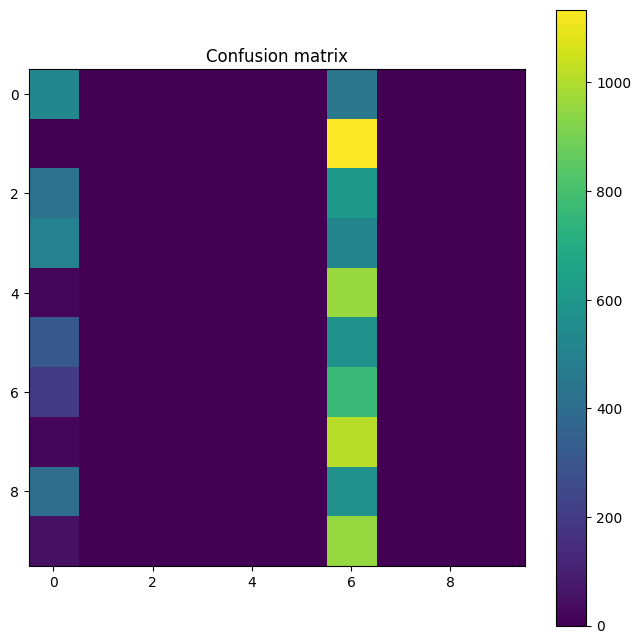

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


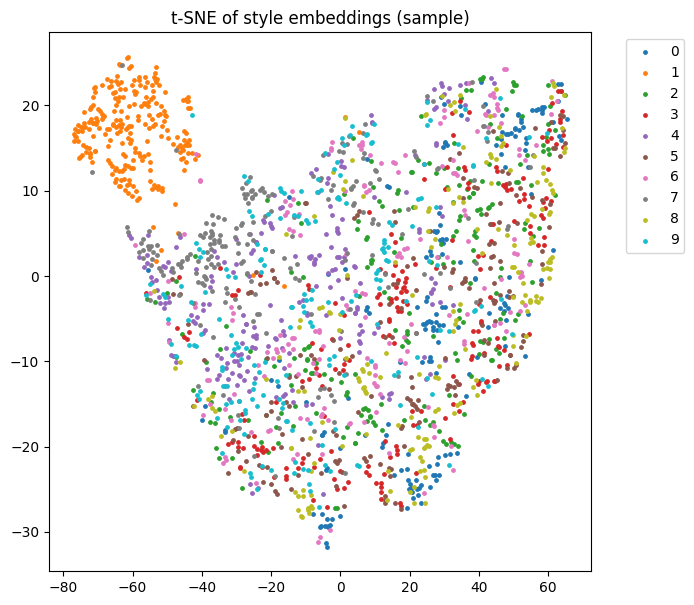

In [ ]:
# Confusion matrix
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        logits, _ = model(imgs)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.numpy().tolist())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 8))
plt.imshow(cm)
plt.colorbar()
plt.title('Confusion matrix')
plt.show()


# t-SNE on style vectors (sample subset for speed)
styles = []
labels = []
with torch.no_grad():
    cnt = 0
    for imgs, labs in val_loader:
        imgs = imgs.to(device)
        _, style = model(imgs)
        styles.append(style.cpu().numpy())
        labels.append(labs.numpy())
        cnt += imgs.size(0)
        if cnt > 2000:
            break

styles = np.concatenate(styles, axis=0)
labels = np.concatenate(labels, axis=0)

emb = TSNE(n_components=2, perplexity=30, init='pca').fit_transform(styles)
plt.figure(figsize=(7, 7))
for cls in np.unique(labels):
    idx = labels == cls
    plt.scatter(emb[idx, 0], emb[idx, 1], label=str(cls), s=6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('t-SNE of style embeddings (sample)')
plt.show()


In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch


def predict_image(model, img_path, device, num_classes=10):
    tf = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    img = Image.open(img_path).convert('L')
    x = tf(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits, style = model(x)
        pred = torch.argmax(logits, dim=1).item()
        probs = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()
        return pred, probs, style.detach().cpu().numpy()


In [ ]:
pred, probs, style = predict_image(model, "/content/Screenshot 2025-08-26 203618.png", device)
print("Pred:", pred, probs)


Pred: 6 [0.10686219 0.09894094 0.10470773 0.09286182 0.1016014  0.10408756
 0.10746412 0.10030153 0.09060965 0.09256313]
